<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1 Mount to Google Drive

The complete computation is done on Google Colab. The following code mounts the Google Drive to the Colab environment.

In [1]:
# mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2 Import relevant libraries and define relevant paths

In [2]:
# for opening installed packages (installed in virtual environment of Google Colab)
import sys
sys.path.append('/content/drive/MyDrive/colab_env/lib/python3.10/site-packages')
# for importing modules defined in other jupyter notebooks
import import_ipynb

In [3]:
# import relevant libraries

import os # for file handling
import glob # for file handling
import random # generate random numbers and seed setting
from tqdm import tqdm # for counter

import numpy as np # for data manipulation
import matplotlib.pyplot as plt # for plotting

from PIL import Image # read and save images
import cv2 # read and save images
from patchify import patchify, unpatchify # for getting patches and 'unpatchifying'

import torch # for PyTorch framework
from torch.utils.data import Dataset, DataLoader # for creating custom dataset and DataLoader
import torchvision.transforms.functional as TF # for tensor transformations and normalization
import albumentations as A # for real-time data augmentation
from torch.optim import Adam # for Adam optimizer
from torch import nn # for defining layers of unet model and resizing
import monai # for medical image segmentation
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis/02_unet'
from unet_dataset import UNETDataset # for custom dataset class
from unet_model import UNET # for U-Net architecture

from sklearn.metrics import accuracy_score, recall_score, precision_score # for evaluation
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis/04_evaluation'
from evaluation_utils import dice_score, iou_score, calculate_metrics, sigmoid # for evaluation
from statistics import mean # calculate mean of metrics

/content/drive/MyDrive/cbs/master_thesis/master-thesis/02_unet
importing Jupyter notebook from unet_dataset.ipynb
importing Jupyter notebook from unet_model.ipynb
/content/drive/MyDrive/cbs/master_thesis/master-thesis/04_evaluation
importing Jupyter notebook from evaluation_utils.ipynb


In [4]:
# define dataset path and target path
dataset_path = '/content/drive/MyDrive/cbs/master_thesis/analysis'

# define model path
model_path = '/content/drive/MyDrive/cbs/master_thesis/models'

### 3 Check U-Net predictions on CAM blood vessel images

#### 3.1 Load trained U-Net model

In [5]:
# load trained U-Net model
unet_model = UNET(in_channels=1, out_channels=1)

# load trained weights
unet_model.load_state_dict(torch.load(os.path.join(model_path, 'unet_model_3.pth')))

<All keys matched successfully>

In [6]:
# set the device to cuda if available, otherwise use cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet_model.to(device)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

#### 3.2 Visual inspection of predicted masks

In [7]:
# load images
# get file names of images
images_files = glob.glob(os.path.join(dataset_path, 'd13_images', '*.jpg'))
images_files.sort()

In [8]:
# apply the same preprocessing steps
# save parameters for preprocessing

# for contrast-limited adaptive histogram equalization (CLAHE)
clahe_value = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# for gamma correction
gamma_value = 1.2

In [9]:
# select image number
image_number = 0

# load image and mask
image = np.array(Image.open(images_files[image_number]).convert('L'))

image = cv2.resize(image, (1024, 1024))

# apply preprocessing
# image normalization (min=0, max=255)
image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# use contrast-limited adaptive histogram equalization (CLAHE)
image = clahe_value.apply(image)

# use gamma correction
image = np.array(255*(image / 255) ** gamma_value, dtype='uint8')

# extract patches of the image
patches = patchify(image, (256, 256), step=256)

# set U-Net model to evaluation mode
unet_model.eval()
# empty list to store patches
predicted_patches = []

# go through all patches and predict mask
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i,j,:,:]
        # transform to tensors and normalize the images
        patch = TF.to_tensor(patch)
        patch = TF.normalize(patch, [0.0], [1.0])
        patch = patch.unsqueeze(0).to(device)
        with torch.no_grad():
            # predict using model
            prediction = unet_model(patch.to(device))
            # remove batch dimension
            prediction = prediction.squeeze().cpu().numpy()
        predicted_patches.append(prediction)

# reshape predicted patches to match the shape of patchify output for unpatchify
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = predicted_patches.reshape(patches.shape[0], patches.shape[1], 256, 256)

# get original mask by 'unpatchifying'
y_prob = unpatchify(predicted_patches_reshaped, (image.shape[0], image.shape[1]))
# apply sigmoid
y_prob = sigmoid(y_prob)
# convert to binary using threshold
y_pred = (y_prob > 0.5).astype(np.float32)

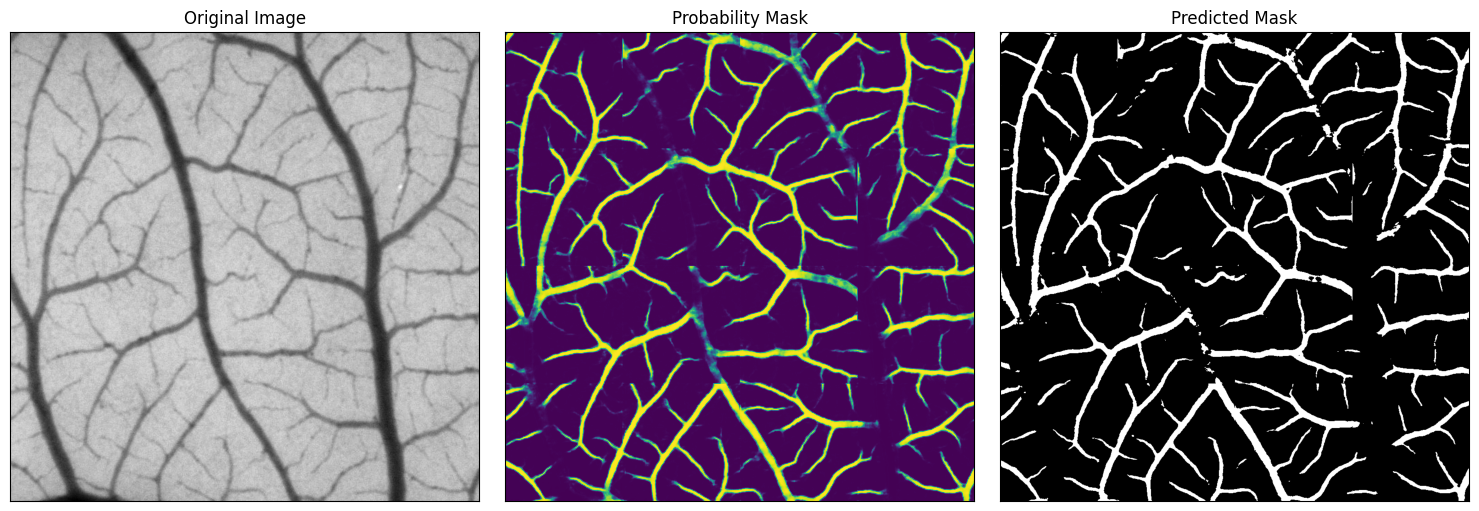

In [10]:
# visualize the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')

# plot probability mask
axes[1].imshow(y_prob)
axes[1].set_title('Probability Mask')

# plot predicted mask
axes[2].imshow(y_pred, cmap='gray')
axes[2].set_title('Predicted Mask')

# hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# adjust spacing between subplots
plt.tight_layout()

# show the images and masks
plt.show()

### 4 Fine-tune U-Net on CAM (Chorioallantoic Membrane) images and masks

Morphological differences require fine-tuning to have a reliable model for analysis. All procedures all equal to the ones in **unet_training.ipynb**.

#### 4.1 Define relevant U-Net functions and load CAM images

In [15]:
# define hyperparameters to tune
batch_size = 32
number_epochs = 10
learning_rate = 0.0001

In [12]:
def extract_patches(image_files_name:list[str], mask_files_name:list[str], patch_size:int=256):
    '''
    Opens images and masks from the given paths and extracts patches of the given size (default: 256x256).

    Args:
        image_files_name (list[str]): Paths to the images.
        mask_files_name (list[str]): Paths to the masks.
        patch_size (int): Size of the quadratic patches.

    Returns:
        images_patches (list): List of image patches.
        masks_patches (list): List of mask patches.
    '''

    # create empty lists to store patches
    images_patches = []
    masks_patches = []

    # for tqdm progress bar
    total_items = len(image_files_name)

    for image_path, mask_path in tqdm(zip(image_files_name, mask_files_name), total=total_items):
        # load images and masks
        image = np.array(Image.open(image_path).convert('L'))  # grayscale
        mask = np.array(Image.open(mask_path).convert('1'))  # binary

        # extract patches of images and masks
        image_patches = patchify(image, (patch_size, patch_size), step=patch_size)
        mask_patches = patchify(mask, (patch_size, patch_size), step=patch_size)

        # flatten patches arrays to list and add to the respective lists
        for i in range(image_patches.shape[0]):
            for j in range(image_patches.shape[1]):
                images_patches.append(image_patches[i,j,:,:])
                masks_patches.append(mask_patches[i,j,:,:])

    return images_patches, masks_patches

In [13]:
# training
# get file names of images
images_files = glob.glob(os.path.join(dataset_path, 'fine_tuning', 'images', '*.jpg'))
images_files.sort()

# get file names of masks
masks_files = glob.glob(os.path.join(dataset_path, 'fine_tuning', 'masks', '*.jpg'))
masks_files.sort()

# shuffle the images
random.seed(42) # set seed for reproducibility
combined = list(zip(images_files, masks_files))
random.shuffle(combined)
images_files, masks_files = zip(*combined)

# split the data 80:10:10 for training, validation, and testing
total_images = len(images_files)
split_train = int(total_images*0.8)
split_val = int(total_images*0.9)

# assign file_names
images_files_train = images_files[:split_train]
masks_files_train = masks_files[:split_train]

images_files_val = images_files[split_train:split_val]
masks_files_val = masks_files[split_train:split_val]

images_files_test = images_files[split_val:]
masks_files_test = masks_files[split_val:]

In [14]:
# extract patches
images_train, masks_train = extract_patches(images_files_train, masks_files_train, patch_size=256)
images_val, masks_val = extract_patches(images_files_val, masks_files_val, patch_size=256)

# remove empty images and masks based on the mask
images_train = [image for image, mask in zip(images_train, masks_train) if np.sum(mask) > 0]
masks_train = [mask for mask in masks_train if np.sum(mask) > 0]
images_val = [image for image, mask in zip(images_val, masks_val) if np.sum(mask) > 0]
masks_val = [mask for mask in masks_val if np.sum(mask) > 0]

100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


In [16]:
# define which transformation is applied to the training images and masks
def custom_transformation(image, mask):
    '''
    Apply custom transformations to the image and mask.
    '''

    transform = A.Compose([
        # horizontal flipping
        A.HorizontalFlip(p=0.5),

        # vertical flipping
        A.VerticalFlip(p=0.5)
    ])

    # apply transformations to both image and mask
    augmented = transform(image=image, mask=mask)

    # return augmented image and mask
    return augmented['image'], augmented['mask']

In [17]:
# create training DataLoader instance
train_dataset = UNETDataset(images=images_train, masks=masks_train, transforms=custom_transformation)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, worker_init_fn=np.random.seed(42))

# create validation DataLoader instance
val_dataset = UNETDataset(images=images_val, masks=masks_val, transforms=None)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [18]:
# load trained U-Net model
unet_model = UNET(in_channels=1, out_channels=1)

# load trained weights
unet_model.load_state_dict(torch.load(os.path.join(model_path, 'unet_model_3.pth')))

<All keys matched successfully>

In [19]:
# set optimizer
optimizer = Adam(unet_model.parameters(), lr=learning_rate, weight_decay=0.01)
# set loss function
seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, reduction='mean')

In [20]:
# define training loop
num_epochs = number_epochs

# use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet_model.to(device)

# track mean train and validation losses
mean_train_losses, mean_val_losses = [], []

# create artificial best validation loss for the start
best_val_loss = 100.0
best_val_epoch = 0

# define patience for early stopping
patience = 5
patience_counter = 0

#### 4.2 Fine-tune U-Net model

In [21]:
# set seed for reproducibility
torch.manual_seed(42) # for PyTorch
torch.backends.cudnn.deterministic = True # for PyTorch
torch.backends.cudnn.benchmark = False # for PyTorch
torch.cuda.manual_seed_all(42) # for GPU
np.random.seed(42) # for numpy
random.seed(42) # for any other operation

# fine-tune SAM model
unet_model.train()
for epoch in range(num_epochs):
    # training stage
    # list to record training losses
    train_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        images, masks = batch
        # use GPU if available
        images = images.to(device)
        masks = masks.float().to(device)
        # calculate loss
        outputs = unet_model(images)
        loss = seg_loss(outputs, masks.unsqueeze(1))

        # backward pass
        # compute gradients of parameters with regards to the loss
        optimizer.zero_grad()
        loss.backward()
        # optimize weights
        optimizer.step()

        train_losses.append(loss.item())

    # validation stage
    # list to record validation losses
    val_losses = []
    # do not calculate gradients during validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):
            # forward pass
            images, masks = val_batch
            # use GPU if available
            images = images.to(device)
            masks = masks.float().to(device)

            # calculate validation loss
            outputs = unet_model(images)
            val_loss = seg_loss(outputs, masks.unsqueeze(1))
            val_losses.append(val_loss.item())

        # save the model when validation loss improves
        # track current validation loss
        current_val_loss = mean(val_losses)
        if current_val_loss < best_val_loss:
            torch.save(unet_model.state_dict(), os.path.join(model_path, 'unet_fine_tuned.pth'))
            print(f'Model saved! Improvement in validation loss: {best_val_loss} to {current_val_loss}')
            best_val_loss = current_val_loss
            # save best validation epoch
            best_val_epoch = epoch+1
            # set patience counter back to 0
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'Model not improved! Patience: {patience_counter}/{patience}')
            # trigger early stopping if patience is reached
            if patience_counter >= patience:
              print(f'Stopping early at epoch {epoch+1}. Best validation loss: {best_val_loss} at epoch {best_val_epoch}')
              break


    # print results of epoch
    print(f'Epoch: {epoch+1}')
    print(f'Mean training loss: {mean(train_losses)}')
    print(f'Mean validation loss: {mean(val_losses)}')

    # append mean training and validation losses
    mean_train_losses.append(mean(train_losses))
    mean_val_losses.append(mean(val_losses))

100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


Model saved! Improvement in validation loss: 100.0 to 0.4256785809993744
Epoch: 1
Mean training loss: 0.48745226114988327
Mean validation loss: 0.4256785809993744


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Model saved! Improvement in validation loss: 0.4256785809993744 to 0.4085744023323059
Epoch: 2
Mean training loss: 0.38672271370887756
Mean validation loss: 0.4085744023323059


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Model saved! Improvement in validation loss: 0.4085744023323059 to 0.4082529842853546
Epoch: 3
Mean training loss: 0.38229938596487045
Mean validation loss: 0.4082529842853546


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Model saved! Improvement in validation loss: 0.4082529842853546 to 0.4034608006477356
Epoch: 4
Mean training loss: 0.3736128980914752
Mean validation loss: 0.4034608006477356


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Model saved! Improvement in validation loss: 0.4034608006477356 to 0.3928237408399582
Epoch: 5
Mean training loss: 0.37433883051077527
Mean validation loss: 0.3928237408399582


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Model not improved! Patience: 1/5
Epoch: 6
Mean training loss: 0.3762264847755432
Mean validation loss: 0.40122371912002563


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


Model not improved! Patience: 2/5
Epoch: 7
Mean training loss: 0.371958148976167
Mean validation loss: 0.39577849209308624


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Model not improved! Patience: 3/5
Epoch: 8
Mean training loss: 0.3689261997739474
Mean validation loss: 0.3982269912958145


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Model saved! Improvement in validation loss: 0.3928237408399582 to 0.39040909707546234
Epoch: 9
Mean training loss: 0.36685094485680264
Mean validation loss: 0.39040909707546234


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Model saved! Improvement in validation loss: 0.39040909707546234 to 0.38596509397029877
Epoch: 10
Mean training loss: 0.3644071693221728
Mean validation loss: 0.38596509397029877


#### 4.3 Evaluate on validation set

In [22]:
# empty dictionaries to store metrics
all_metrics = {}

# define thresholds to optimize
thresholds = [0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]

# set model to evaluation mode
unet_model.eval()

# for tqdm progress bar
total_items = len(images_files_val)

for image_path, mask_path in tqdm(zip(images_files_val, masks_files_val), total=total_items):
    # load image and mask
    image = np.array(Image.open(image_path).convert('L'))
    y_true = np.array(Image.open(mask_path).convert('1'))

    # extract patches of the image
    patches = patchify(image, (256, 256), step=256)

    # empty list to store patches
    predicted_patches = []

    # go through all patches and predict mask
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:]
            # transform to tensors and normalize the images
            patch = TF.to_tensor(patch)
            patch = TF.normalize(patch, [0.0], [1.0])
            patch = patch.unsqueeze(0).to(device)
            with torch.no_grad():
                # predict using model
                prediction = unet_model(patch.to(device))
                # remove batch dimension
                prediction = prediction.squeeze().cpu().numpy()
            predicted_patches.append(prediction)

    # reshape predicted patches to match the shape of patchify output for unpatchify
    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = predicted_patches.reshape(patches.shape[0], patches.shape[1], 256, 256)

    # get original mask by 'unpatchifying'
    y_prob = unpatchify(predicted_patches_reshaped, (image.shape[0], image.shape[1]))
    # apply sigmoid to get probabilities
    y_prob = sigmoid(y_prob)

    # calculate metrics for defined thresholds
    metrics = calculate_metrics(y_true, y_prob, thresholds)

    # aggregate metrics for all images
    for threshold, metric_values in metrics.items():
        if threshold not in all_metrics:
            all_metrics[threshold] = []
        all_metrics[threshold].append(metric_values)

# print mean metrics
for threshold, metric_values in all_metrics.items():
    print(f'\nResults for {threshold}:')
    for metric_name in metric_values[0].keys():
        mean_metric = np.mean([metric[metric_name] for metric in metric_values])
        print(f'Mean {metric_name.capitalize()}: {round(mean_metric, 4)}')

100%|██████████| 3/3 [00:20<00:00,  6.76s/it]


Results for threshold_0.3:
Mean Accuracy: 0.9388
Mean Precision: 0.6961
Mean Recall: 0.8453
Mean Dice: 0.7634
Mean Iou: 0.6179

Results for threshold_0.35:
Mean Accuracy: 0.9408
Mean Precision: 0.7121
Mean Recall: 0.8286
Mean Dice: 0.7658
Mean Iou: 0.6211

Results for threshold_0.4:
Mean Accuracy: 0.9423
Mean Precision: 0.7266
Mean Recall: 0.8114
Mean Dice: 0.7666
Mean Iou: 0.6221

Results for threshold_0.45:
Mean Accuracy: 0.9435
Mean Precision: 0.7416
Mean Recall: 0.7916
Mean Dice: 0.7657
Mean Iou: 0.6209

Results for threshold_0.5:
Mean Accuracy: 0.9443
Mean Precision: 0.7579
Mean Recall: 0.7686
Mean Dice: 0.7631
Mean Iou: 0.6176

Results for threshold_0.55:
Mean Accuracy: 0.9449
Mean Precision: 0.7759
Mean Recall: 0.7419
Mean Dice: 0.7583
Mean Iou: 0.6114

Results for threshold_0.6:
Mean Accuracy: 0.9449
Mean Precision: 0.7939
Mean Recall: 0.7122
Mean Dice: 0.7506
Mean Iou: 0.6015


#### 4.4 Evaluate on test set

In [23]:
# empty dictionaries to store metrics
all_metrics = {}

# define thresholds to optimize
thresholds = [0.40]

# set model to evaluation mode
unet_model.eval()

# for tqdm progress bar
total_items = len(images_files_test)

for image_path, mask_path in tqdm(zip(images_files_test, masks_files_test), total=total_items):
    # load image and mask
    image = np.array(Image.open(image_path).convert('L'))
    y_true = np.array(Image.open(mask_path).convert('1'))

    # extract patches of the image
    patches = patchify(image, (256, 256), step=256)

    # empty list to store patches
    predicted_patches = []

    # go through all patches and predict mask
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:]
            # transform to tensors and normalize the images
            patch = TF.to_tensor(patch)
            patch = TF.normalize(patch, [0.0], [1.0])
            patch = patch.unsqueeze(0).to(device)
            with torch.no_grad():
                # predict using model
                prediction = unet_model(patch.to(device))
                # remove batch dimension
                prediction = prediction.squeeze().cpu().numpy()
            predicted_patches.append(prediction)

    # reshape predicted patches to match the shape of patchify output for unpatchify
    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = predicted_patches.reshape(patches.shape[0], patches.shape[1], 256, 256)

    # get original mask by 'unpatchifying'
    y_prob = unpatchify(predicted_patches_reshaped, (image.shape[0], image.shape[1]))
    # apply sigmoid to get probabilities
    y_prob = sigmoid(y_prob)

    # calculate metrics for defined thresholds
    metrics = calculate_metrics(y_true, y_prob, thresholds)

    # aggregate metrics for all images
    for threshold, metric_values in metrics.items():
        if threshold not in all_metrics:
            all_metrics[threshold] = []
        all_metrics[threshold].append(metric_values)

# print mean metrics
for threshold, metric_values in all_metrics.items():
    print(f'\nResults for {threshold}:')
    for metric_name in metric_values[0].keys():
        mean_metric = np.mean([metric[metric_name] for metric in metric_values])
        print(f'Mean {metric_name.capitalize()}: {round(mean_metric, 4)}')

100%|██████████| 3/3 [00:07<00:00,  2.59s/it]


Results for threshold_0.4:
Mean Accuracy: 0.9364
Mean Precision: 0.7058
Mean Recall: 0.8742
Mean Dice: 0.7804
Mean Iou: 0.6404


### 5 Predict and save masks using fine-tuned U-Net model

#### 5.1 Load model

In [25]:
# load trained U-Net model
unet_model = UNET(in_channels=1, out_channels=1)

# load trained weights
unet_model.load_state_dict(torch.load(os.path.join(model_path, 'unet_fine_tuned.pth')))

# use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet_model.to(device)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

#### 5.2 Visual inspection of predicted mask

In [26]:
# save parameters for preprocessing

# for contrast-limited adaptive histogram equalization (CLAHE)
clahe_value = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# for gamma correction
gamma_value = 1.2

In [27]:
# load images
# get file names of images
images_files = glob.glob(os.path.join(dataset_path, 'd13_images', '*.jpg'))
images_files.sort()

In [29]:
# select random image number
image_number = 0

# load image and mask
image = np.array(Image.open(images_files[image_number]).convert('L'))

image = cv2.resize(image, (1024, 1024))

# apply preprocessing
# image normalization (min=0, max=255)
image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# use contrast-limited adaptive histogram equalization (CLAHE)
image = clahe_value.apply(image)

# use gamma correction
image = np.array(255*(image / 255) ** gamma_value, dtype='uint8')

# extract patches of the image
patches = patchify(image, (256, 256), step=256)

# set U-Net model to evaluation mode
unet_model.eval()
# empty list to store patches
predicted_patches = []

# go through all patches and predict mask
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i,j,:,:]
        # transform to tensors and normalize the images
        patch = TF.to_tensor(patch)
        patch = TF.normalize(patch, [0.0], [1.0])
        patch = patch.unsqueeze(0).to(device)
        with torch.no_grad():
            # predict using model
            prediction = unet_model(patch.to(device))
            # remove batch dimension
            prediction = prediction.squeeze().cpu().numpy()
        predicted_patches.append(prediction)

# reshape predicted patches to match the shape of patchify output for unpatchify
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = predicted_patches.reshape(patches.shape[0], patches.shape[1], 256, 256)

# get original mask by 'unpatchifying'
y_prob = unpatchify(predicted_patches_reshaped, (image.shape[0], image.shape[1]))
# apply sigmoid
y_prob = sigmoid(y_prob)
# convert to binary using threshold
y_pred = (y_prob > 0.4).astype(np.float32)

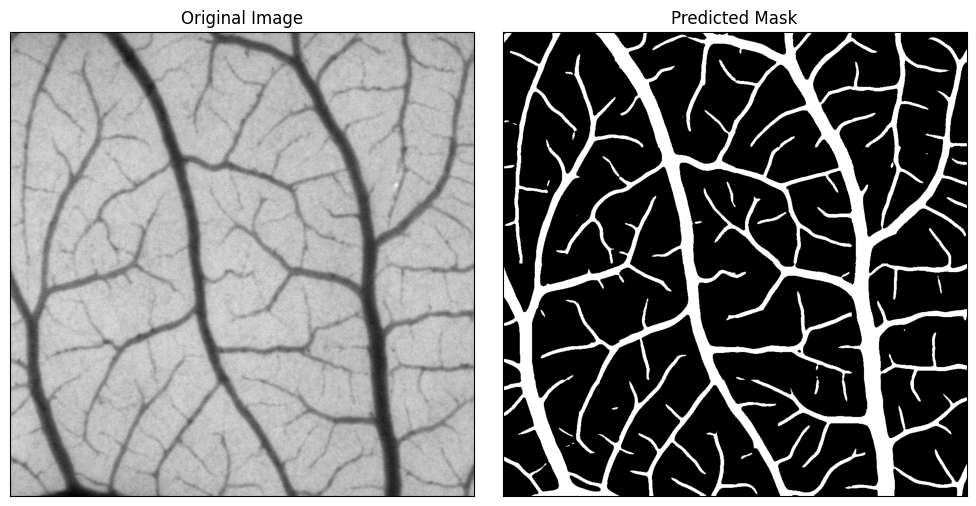

In [30]:
# visualize the results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# plot original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')

# plot predicted mask
axes[1].imshow(y_pred, cmap='gray')
axes[1].set_title('Predicted Mask')

# hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# adjust spacing between subplots
plt.tight_layout()

# show the images and masks
plt.show()

#### 5.3 Predict and save masks

In [32]:
# load images, apply pre-processing, and save them
def get_mask(images_files, target_folder):
    '''
    '''
    for image_file in tqdm(images_files):
        # load image
        image = np.array(Image.open(image_file).convert('L'))

        # apply preprocessing
        # image normalization (min=0, max=255)
        image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        # use contrast-limited adaptive histogram equalization (CLAHE)
        image = clahe_value.apply(image)

        # use gamma correction
        image = np.array(255*(image / 255) ** gamma_value, dtype='uint8')

        # calculate the mask based on U-Net
        # set U-Net model to evaluation mode
        unet_model.eval()

        # extract patches of the image
        patches = patchify(image, (256, 256), step=256)

        # empty list to store patches
        predicted_patches = []

        # go through all patches and predict mask
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                patch = patches[i,j,:,:]
                # transform to tensors and normalize the images
                patch = TF.to_tensor(patch)
                patch = TF.normalize(patch, [0.0], [1.0])
                patch = patch.unsqueeze(0).to(device)
                with torch.no_grad():
                    # predict using model
                    prediction = unet_model(patch.to(device))
                    # remove batch dimension
                    prediction = prediction.squeeze().cpu().numpy()
                predicted_patches.append(prediction)

        # reshape predicted patches to match the shape of patchify output for unpatchify
        predicted_patches = np.array(predicted_patches)
        predicted_patches_reshaped = predicted_patches.reshape(patches.shape[0], patches.shape[1], 256, 256)

        # get original mask by 'unpatchifying'
        y_prob = unpatchify(predicted_patches_reshaped, (image.shape[0], image.shape[1]))
        # convert to binary using threshold
        y_pred = (y_prob > 0.4).astype(np.float32)

        # get image file name
        name = os.path.basename(image_file)
        # save image in target folder
        cv2.imwrite(os.path.join(target_folder, name), y_pred*255)

In [33]:
# get mask of day 11 images
images_day_11 = glob.glob(os.path.join(dataset_path, 'd11_images', '*.jpg'))
get_mask(images_files=images_day_11, target_folder=os.path.join(dataset_path, 'd11_masks'))

100%|██████████| 25/25 [00:40<00:00,  1.62s/it]


In [34]:
# get mask of day 13 images
images_day_13 = glob.glob(os.path.join(dataset_path, 'd13_images', '*.jpg'))
get_mask(images_files=images_day_13, target_folder=os.path.join(dataset_path, 'd13_masks'))

100%|██████████| 25/25 [00:39<00:00,  1.59s/it]
